In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
!unzip /content/drive/MyDrive/DATASET.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATASET/TRAIN/R/R_5000.jpg  
  inflating: DATASET/TRAIN/R/R_5001.jpg  
  inflating: DATASET/TRAIN/R/R_5002.jpg  
  inflating: DATASET/TRAIN/R/R_5003.jpg  
  inflating: DATASET/TRAIN/R/R_5004.jpg  
  inflating: DATASET/TRAIN/R/R_5005.jpg  
  inflating: DATASET/TRAIN/R/R_5006.jpg  
  inflating: DATASET/TRAIN/R/R_5007.jpg  
  inflating: DATASET/TRAIN/R/R_5008.jpg  
  inflating: DATASET/TRAIN/R/R_5009.jpg  
  inflating: DATASET/TRAIN/R/R_5010.jpg  
  inflating: DATASET/TRAIN/R/R_5011.jpg  
  inflating: DATASET/TRAIN/R/R_5012.jpg  
  inflating: DATASET/TRAIN/R/R_5013.jpg  
  inflating: DATASET/TRAIN/R/R_5014.jpg  
  inflating: DATASET/TRAIN/R/R_5015.jpg  
  inflating: DATASET/TRAIN/R/R_5016.jpg  
  inflating: DATASET/TRAIN/R/R_5017.jpg  
  inflating: DATASET/TRAIN/R/R_5018.jpg  
  inflating: DATASET/TRAIN/R/R_5019.jpg  
  inflating: DATASET/TRAIN/R/R_5020.jpg  
  inflating: DATASET/TRAIN/R/R_5021.jpg  
  inflating: DATASET/TRAI

In [19]:
my_data_dir = "/content/DATASET"

In [20]:
os.listdir(my_data_dir)

['TEST', 'TRAIN']

In [21]:
test_path = my_data_dir+'/TEST'
train_path = my_data_dir+'/TRAIN'

In [22]:
os.listdir(train_path)

['N', 'R', 'O']

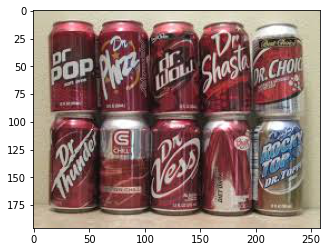

In [23]:
N = train_path+'/N'+'/'+os.listdir(train_path+'/N')[2]
N_img= imread(N)
plt.imshow(N_img)

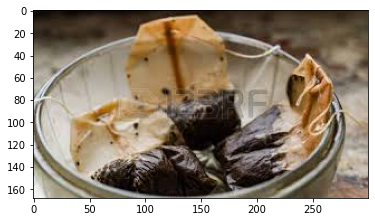

In [24]:
O = train_path+'/O'+'/'+os.listdir(train_path+'/O')[0]
O_img= imread(O)
plt.imshow(O_img)

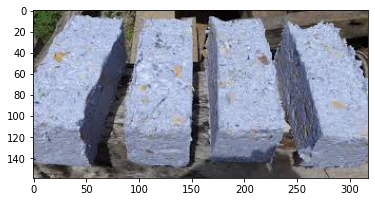

In [25]:
R = train_path+'/R'+'/'+os.listdir(train_path+'/R')[98]
R_img= imread(R)
plt.imshow(R_img)

In [26]:
print("For training data:")
print("N: "+str(len(os.listdir(train_path+'/N'))))
print("O: "+str(len(os.listdir(train_path+'/O'))))
print("R: "+str(len(os.listdir(train_path+'/R'))))

For training data:
N: 2847
O: 12565
R: 7152


In [27]:
print("For testing data:")
print("N: "+str(len(os.listdir(test_path+'/N'))))
print("O: "+str(len(os.listdir(test_path+'/O'))))
print("R: "+str(len(os.listdir(test_path+'/R'))))

For testing data:
N: 397
O: 1401
R: 1112


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

In [30]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224,224),
        batch_size=256,
        class_mode='categorical',
        shuffle=True
)

Found 22564 images belonging to 3 classes.


In [32]:
validation_generator = val_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=256,
        class_mode='categorical',
        shuffle=False
)

Found 2907 images belonging to 3 classes.


In [33]:
img_size = 224
batch_size = 256

In [34]:
train_generator.class_indices

{'N': 0, 'O': 1, 'R': 2}

In [35]:
class_names=['Non-Recyclable','Organic','Recyclable']

In [36]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [37]:
from tensorflow.keras.applications import Xception 

In [38]:
base_model = Xception(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

83689472/83683744 [==============================] - 1s 0us/step


In [39]:
for layer in base_model.layers:
    layer.trainable=False

In [40]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [42]:
model=Sequential()

model.add(base_model)
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation="softmax"))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

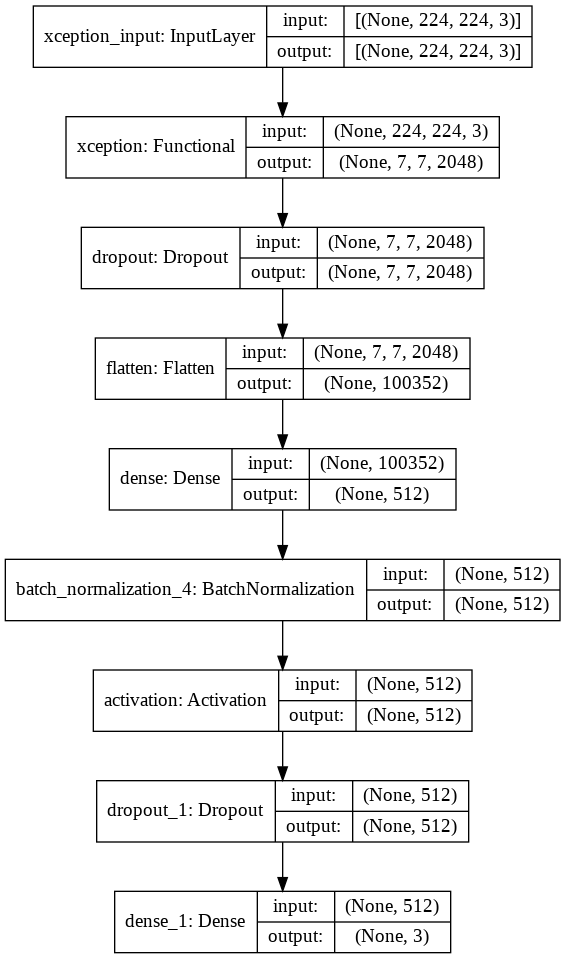

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='Xceptionmodel.png', show_shapes=True, show_layer_names=True)

In [46]:
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint('Xception.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_weights_only=True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_acc',
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

callback_list = [earlystopping, checkpoint]

In [ ]:
history=model.fit(train_generator,
                validation_data=validation_generator,
                epochs=3,
                callbacks=callback_list,
                verbose=1,  
)

Epoch 1/3
89/89 [==============================] - 3184s 36s/step - loss: 0.4744 - accuracy: 0.8599 - val_loss: 0.7247 - val_accuracy: 0.7317

Epoch 00001: saving model to Xception.h5
Epoch 2/3
89/89 [==============================] - 3149s 35s/step - loss: 0.2549 - accuracy: 0.9038 - val_loss: 0.7768 - val_accuracy: 0.7214

Epoch 00002: saving model to Xception.h5
Epoch 3/3
89/89 [==============================] - 3073s 35s/step - loss: 0.2170 - accuracy: 0.9173 - val_loss: 0.5472 - val_accuracy: 0.8067

Epoch 00003: saving model to Xception.h5


In [ ]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("Xceptionmodel.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("Xceptionmodel.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [80]:
from tensorflow.keras.models import model_from_json
with open('/content/drive/MyDrive/waste classification weights/Xceptionmodel.json','r') as f:
    json = f.read()
model = model_from_json(json)
#best m0del weight
model.load_weights("/content/drive/MyDrive/waste classification weights/Xceptionmodel.h5")

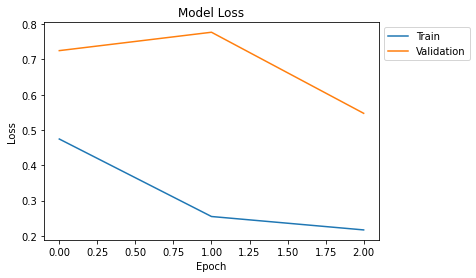

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

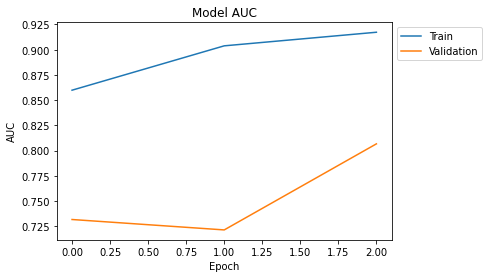

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
model.evaluate(validation_generator)

12/12 [==============================] - 339s 28s/step - loss: 0.5472 - accuracy: 0.8067


[0.5472220778465271, 0.806673526763916]

In [82]:
preds = model.predict(validation_generator)
pred = []
for i in preds:
    pred.append(np.argmax(i))

In [83]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [51]:
validation_generator.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [84]:
print(confusion_matrix(validation_generator.classes, pred))

[[ 279   17   98]
 [   1 1380   20]
 [  82  344  686]]


In [85]:
df=confusion_matrix(validation_generator.classes, pred)

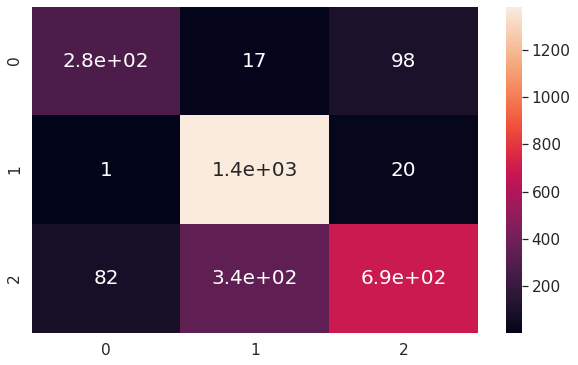

In [86]:
df_cm = pd.DataFrame(df, range(3), range(3))
plt.figure(figsize=(10,6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 20}) # font size

plt.show()

In [87]:
print(classification_report(validation_generator.classes, pred,target_names=class_names))

                precision    recall  f1-score   support

Non-Recyclable       0.77      0.71      0.74       394
       Organic       0.79      0.99      0.88      1401
    Recyclable       0.85      0.62      0.72      1112

      accuracy                           0.81      2907
     macro avg       0.81      0.77      0.78      2907
  weighted avg       0.81      0.81      0.80      2907



In [88]:
encoder_model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               51380736  
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0   

In [89]:
encoder_model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               51380736  
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0   

In [90]:
output_train=encoder_model.predict(train_generator)
output_test=encoder_model.predict(validation_generator)

In [91]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_generator.labels)
test_labels = to_categorical(validation_generator.labels)
print("Train Labels", train_labels.shape)
print("Test Labels", test_labels.shape)

Train Labels (22564, 3)
Test Labels (2907, 3)


In [92]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 42)

In [93]:
rf_model.fit(output_train, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [94]:
rf_preds = rf_model.predict(output_test)

In [95]:
print(confusion_matrix(validation_generator.classes,rf_preds.argmax(axis=1)))

[[  88  306    0]
 [ 123 1278    0]
 [  50 1062    0]]


In [96]:
df=confusion_matrix(validation_generator.classes,rf_preds.argmax(axis=1))

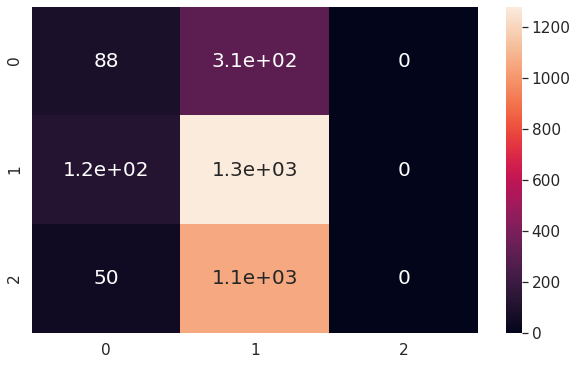

In [97]:
df_cm = pd.DataFrame(df, range(3), range(3))
plt.figure(figsize=(10,6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 20}) # font size

plt.show()

In [98]:
print(classification_report(test_labels.argmax(axis=1),rf_preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.34      0.22      0.27       394
           1       0.48      0.91      0.63      1401
           2       0.00      0.00      0.00      1112

    accuracy                           0.47      2907
   macro avg       0.27      0.38      0.30      2907
weighted avg       0.28      0.47      0.34      2907



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
from xgboost import XGBClassifier

In [100]:
xgb_model = XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=100, random_state=24) 

In [101]:
xgb_model.fit(output_train, train_generator.classes)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=24,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [102]:
xgb_preds = xgb_model.predict(output_test)

In [103]:
print(confusion_matrix(validation_generator.classes,xgb_preds))

[[   1  390    3]
 [   0 1394    7]
 [   0 1112    0]]


In [104]:
df=confusion_matrix(validation_generator.classes,xgb_preds)

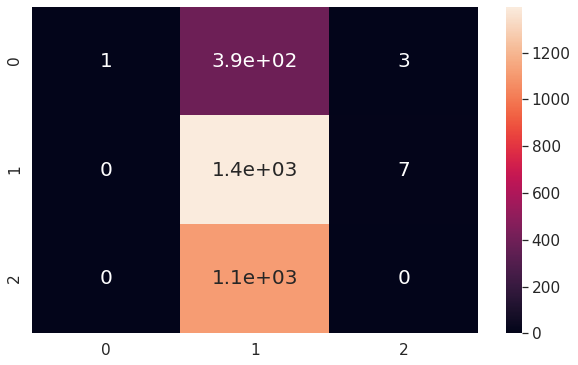

In [105]:
df_cm = pd.DataFrame(df, range(3), range(3))
plt.figure(figsize=(10,6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 20}) # font size

plt.show()

In [106]:
print(classification_report(test_labels.argmax(axis=1),xgb_preds))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       394
           1       0.48      1.00      0.65      1401
           2       0.00      0.00      0.00      1112

    accuracy                           0.48      2907
   macro avg       0.49      0.33      0.22      2907
weighted avg       0.37      0.48      0.31      2907

